In [ ]:
# src / main 

In [ ]:
project_root = os.getcwd()
src_dir = os.path.join(project_root, 'src')

if src_dir not in sys.path:
    sys.path.append(src_dir)

In [41]:
print(project_root)

/Users/margheritathermes/Desktop/3HALF/advanced programming for data science/portfolio/group_25


In [122]:
import os
import urllib.request
import zipfile
import pandas as pd
import sys
# Adjust the sys.path to include the src directory for module imports
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from utils.distance_calculations import haversine




import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns


class FlightDataAnalysis:
    def __init__(self):
        self.data_dir = '../downloads'
        self.file_name = 'flight_data.zip'
        self.processed_data_dir = '../data/processed'
        self.download_url = 'https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false'
        self.dataset_names = ['airlines', 'airplanes', 'airports', 'routes']

        os.makedirs(self.data_dir, exist_ok=True)
        self.ensure_data_downloaded_and_extracted()
        self.load_and_preprocess_datasets()

    def ensure_data_downloaded_and_extracted(self):
        file_path = os.path.join(self.data_dir, self.file_name)
        if not all(os.path.exists(os.path.join(self.data_dir, f'{name}.csv')) for name in self.dataset_names):
            if not os.path.exists(file_path):
                self.download_data(file_path)
            self.extract_zip(file_path)

    def download_data(self, file_path):
        print(f"Downloading data to {file_path}...")
        urllib.request.urlretrieve(self.download_url, file_path)
        print("Download completed.")

    def extract_zip(self, file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(self.data_dir)
        os.remove(file_path)
        print("Extraction completed.")

    def load_and_preprocess_datasets(self):
        """Loads datasets and preprocesses them."""
        self.load_datasets()
        self.preprocess_datasets()
        # Apply distance enrichment after preprocessing
        self.enrich_routes_with_distances()

    def load_datasets(self):
        """Loads datasets into memory."""
        for name in self.dataset_names:
            csv_path = os.path.join(self.data_dir, f'{name}.csv')
            setattr(self, name, pd.read_csv(csv_path))
        print("Datasets loaded into memory.")

    def preprocess_datasets(self):
        """Preprocesses datasets and updates class attributes with preprocessed data."""
        columns_to_keep = {
            'airports': ['Name', 'City', 'Country', 'Latitude', 'Longitude', 'Airport ID', 'IATA', 'ICAO'],
            'airplanes': ['Name', 'IATA code', 'ICAO code'],
            'routes': ['Airline', 'Source airport', 'Destination airport', 'Stops', 'Destination airport ID', 'Source airport ID', 'Equipment'],
            'airlines': ['Name', 'Country']
        }

        print("Checking for existing processed datasets...")
        os.makedirs(self.processed_data_dir, exist_ok=True)

        for name in self.dataset_names:
            processed_file_path = os.path.join(self.processed_data_dir, f'{name}_processed.csv')
            if os.path.exists(processed_file_path):
                dataset = pd.read_csv(processed_file_path)
                print(f"Using existing processed file {processed_file_path}.")
            else:
                dataset = getattr(self, name)
                dataset = dataset[[col for col in columns_to_keep[name] if col in dataset.columns]].dropna()
                dataset.to_csv(processed_file_path, index=False)
                print(f"{name} dataset preprocessed and saved to {processed_file_path}.")

            # Update class attributes with preprocessed datasets
            setattr(self, name, dataset)

        print("All datasets processed and updated as class attributes.")

    def enrich_routes_with_distances(self):
        """Enriches the routes dataset with calculated distances using preprocessed data."""
        if not hasattr(self, 'airports') or not hasattr(self, 'routes'):
            print("Required datasets are not loaded.")
            return

        airport_coords = {row['IATA']: (row['Latitude'], row['Longitude'])
                          for _, row in self.airports.iterrows() if row['IATA']}

        distances = []
        for _, row in self.routes.iterrows():
            source = row['Source airport']
            destination = row['Destination airport']
            try:
                source_lat, source_lon = airport_coords[source]
                dest_lat, dest_lon = airport_coords[destination]
                distance = haversine(source_lat, source_lon, dest_lat, dest_lon)
            except KeyError:
                distance = float('nan')
            
            distances.append(distance)

        self.routes['Distance'] = distances
        print("Distances successfully added to the preprocessed routes dataset.")






    def plot_airports_by_country(self, country_name):
        """Plots airports' locations for a given country."""
        # Filter the airports dataset for the specified country
        country_airports = self.airports[self.airports['Country'].str.lower() == country_name.lower()]
        
        if country_airports.empty:
            print(f"No airports found for the country: {country_name}")
            return
        
        # Initialize a figure
        plt.figure(figsize=(10, 8))
        
        # Set up the Basemap
        # Note: You may need to adjust the projection and bounding box to better fit the country's geography
        m = Basemap(projection='merc', llcrnrlat=country_airports['Latitude'].min() - 5,
                    urcrnrlat=country_airports['Latitude'].max() + 5,
                    llcrnrlon=country_airports['Longitude'].min() - 5,
                    urcrnrlon=country_airports['Longitude'].max() + 5, lat_ts=20, resolution='i')
        
        m.drawcountries()
        m.drawcoastlines()
        
        # Convert airport latitudes and longitudes to map projection coordinates
        lons, lats = m(country_airports['Longitude'].values, country_airports['Latitude'].values)
        
        # Plot the airports
        m.scatter(lons, lats, marker='o', color='red', zorder=5)
        
        plt.title(f"Airports in {country_name}")
        plt.show()

    def distance_analysis(self):
        """Plots the distribution of flight distances for all flights."""
        # Check if the routes dataset has the 'Distance' column
        if 'Distance' not in self.routes.columns:
            print("The dataset does not have distance data. Ensure you've run enrich_routes_with_distances.")
            return
        
        # Plotting the distribution using seaborn for a better-looking histogram
        plt.figure(figsize=(10, 6))
        sns.histplot(self.routes['Distance'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Flight Distances')
        plt.xlabel('Distance (km)')
        plt.ylabel('Frequency')
        plt.show()
    

    def plot_flights_from_airport(self, airport_iata, internal=False):
        """Plots flights leaving from a given airport. If 'internal' is True, only plots domestic flights."""
        # Filter the routes to get those departing from the specified airport
        departures = self.routes[self.routes['Source airport'] == airport_iata]

        if internal:
            # Further filter to get only domestic flights
            # This requires matching the 'Destination airport' with the 'Country' of the departure airport
            departure_country = self.airports[self.airports['IATA'] == airport_iata]['Country'].values[0]
            departures = departures[departures['Destination airport'].isin(self.airports[self.airports['Country'] == departure_country]['IATA'])]

        if departures.empty:
            print(f"No {'domestic' if internal else 'international'} flights found departing from {airport_iata}.")
            return
        
        # For simplicity, this example will just print out the destinations.
        # Replace this section with your plotting logic, depending on your choice of plotting library and data format.
        print(f"Flights departing from {airport_iata} {'(Domestic)' if internal else '(International)'}:")
        for _, flight in departures.iterrows():
            print(f"- To {flight['Destination airport']}")


    def plot_top_airplane_models(self, countries=None, top_n=10):
        """Plots the top N most used airplane models for the specified countries or globally if countries is None."""
        # Filter the routes dataset based on the country/countries if provided
        if countries is not None:
            if isinstance(countries, str):
                countries = [countries]  # Convert to list if only one country is provided
            
            # Filter airports by the specified countries
            airports_in_countries = self.airports[self.airports['Country'].isin(countries)]['IATA']
            # Filter routes where either source or destination airport is in the specified countries
            filtered_routes = self.routes[self.routes['Source airport'].isin(airports_in_countries) | 
                                          self.routes['Destination airport'].isin(airports_in_countries)]
        else:
            filtered_routes = self.routes

        # Count the frequency of each airplane model in the filtered routes
        model_counts = filtered_routes['Equipment'].str.split(' ', expand=True).stack().value_counts().head(top_n)

        # Plotting
        plt.figure(figsize=(10, 8))
        model_counts.plot(kind='bar')
        plt.title(f"Top {top_n} Most Used Airplane Models {'Globally' if countries is None else 'in ' + ', '.join(countries)}")
        plt.xlabel('Airplane Model')
        plt.ylabel('Number of Routes')
        plt.xticks(rotation=45)
        plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
        plt.show()


    def plot_flights_by_country(self, country_name, internal=False):
        """Plots flights leaving from a given country. If 'internal' is True, only plots domestic flights."""
        # Filter the airports to get those in the specified country
        country_airports = self.airports[self.airports['Country'].str.lower() == country_name.lower()]
        
        if country_airports.empty:
            print(f"No airports found for the country: {country_name}")
            return
        
        # Get the IATA codes of airports in the specified country
        country_airports_iata = country_airports['IATA'].tolist()
        
        # Filter the routes to get those departing from the specified country
        departures = self.routes[self.routes['Source airport'].isin(country_airports_iata)]
        
        if internal:
            # Further filter to get only domestic flights within the same country
            departures = departures[departures['Destination airport'].isin(country_airports_iata)]
        else:
            # Optionally, filter out to show only international flights
            departures = departures[~departures['Destination airport'].isin(country_airports_iata)]

        if departures.empty:
            print(f"No {'domestic' if internal else 'international'} flights found for the country: {country_name}.")
            return
        
        # For simplicity, this example will just print out the number of flights.
        # You might want to replace this with actual plotting logic.
        num_flights = len(departures)
        print(f"Number of {'domestic' if internal else 'international'} flights from {country_name}: {num_flights}")
        


   




    



# Initialize the class to start the process
analysis = FlightDataAnalysis()


Datasets loaded into memory.
Checking for existing processed datasets...
Using existing processed file ../data/processed/airlines_processed.csv.
Using existing processed file ../data/processed/airplanes_processed.csv.
Using existing processed file ../data/processed/airports_processed.csv.
Using existing processed file ../data/processed/routes_processed.csv.
All datasets processed and updated as class attributes.
Distances successfully added to the preprocessed routes dataset.


In [87]:
analysis.routes.Distance.dropnan(i

0        1506.825604
1        1040.438320
2         448.164909
3         770.508500
4        1338.631467
            ...     
67658     229.720619
67659    2942.819259
67660    2942.819259
67661     306.295375
67662     306.295375
Name: Distance, Length: 67663, dtype: float64

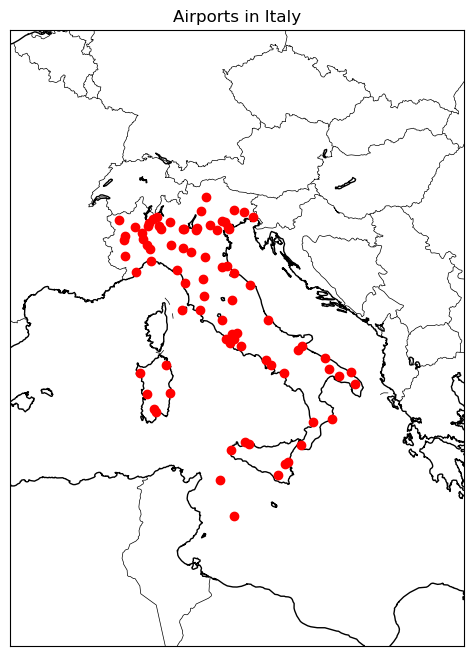

In [70]:
analysis.plot_airports_by_country('Italy')

/Users/margheritathermes/anaconda3/envs/adpro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


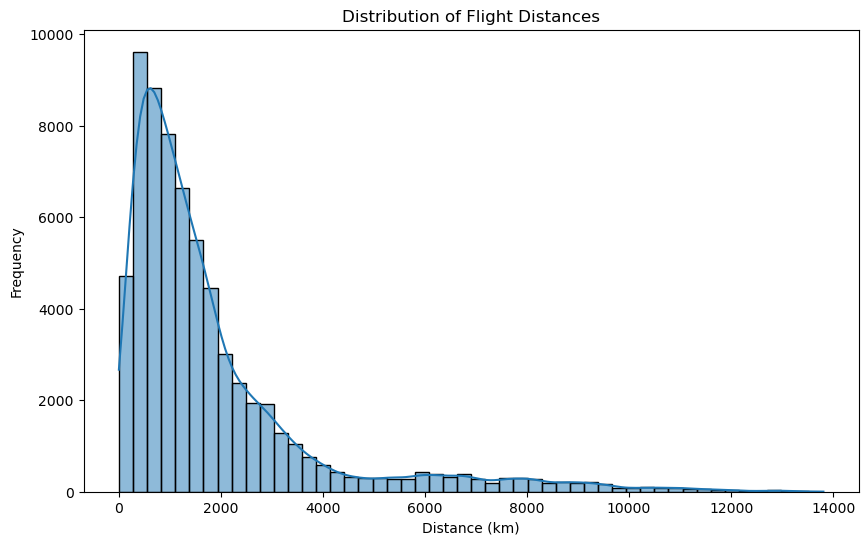

In [123]:
analysis.distance_analysis()

In [109]:

analysis.plot_flights_from_airport('JFK')  # Plot all flights departing from JFK
analysis.plot_flights_from_airport('JFK', internal=True)  # Plot internal flights departing from JFK


Flights departing from JFK (International):
- To EZE
- To MEX
- To MSY
- To AMM
- To ANU
- To AUH
- To AUS
- To BCN
- To BDA
- To BNA
- To BOS
- To BWI
- To CCS
- To CDG
- To CLE
- To CLT
- To CMH
- To CUN
- To CVG
- To DCA
- To DFW
- To DOH
- To DUB
- To DUS
- To EZE
- To FCO
- To GIG
- To GRU
- To GYE
- To HEL
- To HKG
- To IND
- To LAS
- To LAX
- To LCY
- To LHR
- To LIM
- To MAD
- To MAN
- To MCO
- To MIA
- To MXP
- To NRT
- To ORD
- To ORF
- To ORY
- To PAP
- To PHX
- To PIT
- To RDU
- To SAN
- To SCL
- To SEA
- To SFO
- To SJO
- To SJU
- To STT
- To SXM
- To TPA
- To TXL
- To YUL
- To YYC
- To YYZ
- To ZRH
- To DUS
- To TXL
- To YYZ
- To ATL
- To BCN
- To BRU
- To CDG
- To DUB
- To FRA
- To LHR
- To MAD
- To MSY
- To NCE
- To PAP
- To DEL
- To LHR
- To ATL
- To CUN
- To MEX
- To EZE
- To LAX
- To SAN
- To SEA
- To SFO
- To CMN
- To BOG
- To MDE
- To SAL
- To SAP
- To BCN
- To CDG
- To DUB
- To FCO
- To HEL
- To LCY
- To LHR
- To MAD
- To MAN
- To MXP
- To SJU
- To YUL
- To YYZ
- 

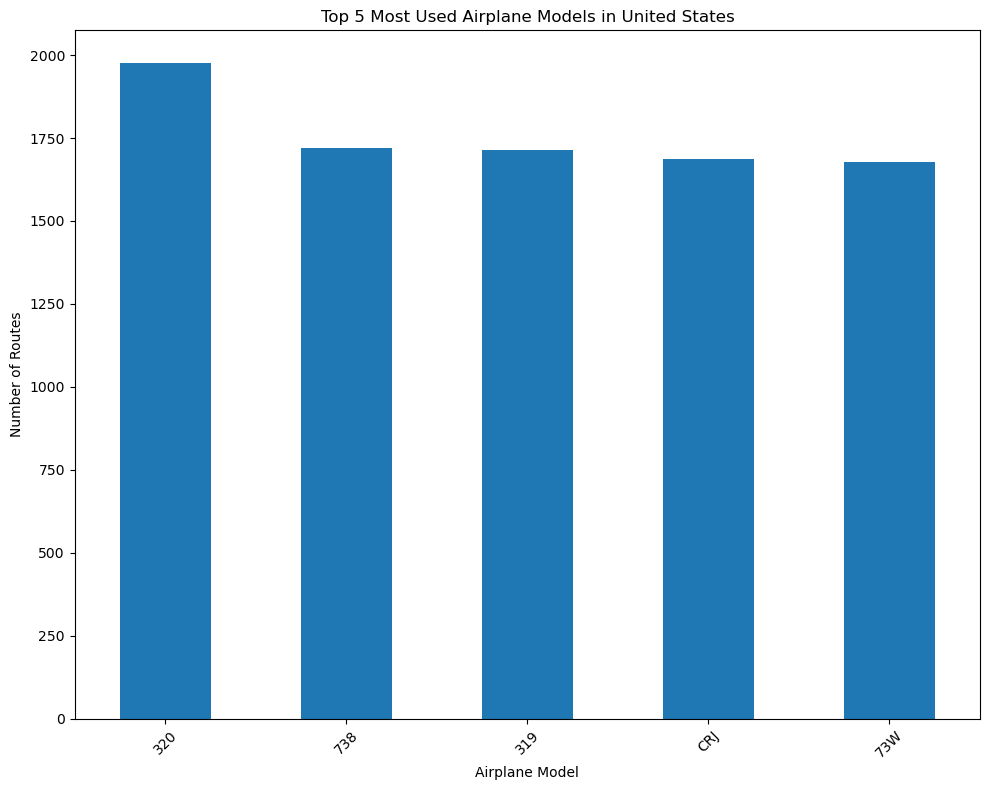

In [115]:

analysis.plot_top_airplane_models('United States', top_n=5)  # For a single country

In [121]:
analysis.plot_flights_by_country('Italy', internal = False)

Number of international flights from Italy: 1351


In [124]:
import os
import urllib.request
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List
from mpl_toolkits.basemap import Basemap
import sys
import math

project_root = os.getcwd()
src_dir = os.path.join(project_root, 'src')

if src_dir not in sys.path:
    sys.path.append(src_dir)

# Now you can import your module using the modified system path
from utils.distance_calculations import haversine_distance



class FlightDataAnalysis:
    """
    A class for analyzing and visualizing flight data, including functionality
    for data downloading, preprocessing, enrichment with distances, and plotting.

    Attributes
    ----------
    data_dir : str
        The directory path where raw data files are downloaded and stored.
    file_name : str
        The name of the zip file containing all the raw datasets.
    processed_data_dir : str
        The directory path where processed data files are stored.
    download_url : str
        The URL from which the zip file containing the datasets is downloaded.
    dataset_names : List[str]
        A list of names of the datasets to be processed.

    Methods
    -------
    ensure_data_downloaded_and_extracted():
        Ensures that the dataset zip file is downloaded and extracted.
    download_data(file_path: str):
        Downloads the dataset zip file from the `download_url`.
    extract_zip(file_path: str):
        Extracts the downloaded zip file into the `data_dir`.
    load_and_preprocess_datasets():
        Loads datasets into memory and preprocesses them according to specified criteria.
    load_datasets():
        Loads datasets from CSV files into pandas DataFrames.
    preprocess_datasets():
        Preprocesses the datasets, keeping only necessary columns and handling missing values.
    enrich_routes_with_distances():
        Enriches the routes dataset with distances calculated between the source and destination airports.
    plot_airports_by_country(country_name: str):
        Plots the locations of airports within a specified country on a map.
    distance_analysis():
        Plots the distribution of flight distances across all flights in the dataset.
    plot_flights_from_airport(airport_iata: str, internal: bool = False):
        Plots flights departing from a specific airport, optionally filtering for domestic flights.
    plot_top_airplane_models(countries: Optional[List[str]] = None, top_n: int = 10):
        Plots the top N most used airplane models, optionally filtered by country or countries.
    plot_flights_by_country(country_name: str, internal: bool = False):
        Plots flights departing from a specified country, optionally filtering for domestic flights.
    """
    
    def __init__(self, base_path=None):
        """
        Initializes the FlightDataAnalysis instance. If base_path is not provided,
        it uses the current working directory as the base path.

        Parameters
        ----------
        base_path : str, optional
            The base path where the 'downloads' and 'data/processed' directories are located.
            If not provided, the current working directory is used.
        """
        if base_path is None:
            # If no base path is given, assume the current working directory
            base_path = os.getcwd()
        
        self.data_dir = os.path.join(base_path, 'downloads')
        self.processed_data_dir = os.path.join(base_path, 'data', 'processed')
        self.download_url = 'https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false'
        self.dataset_names = ['airlines', 'airplanes', 'airports', 'routes']
        self.file_name = 'flight_data.zip'

        # Make sure the directories exist
        os.makedirs(self.data_dir, exist_ok=True)
        os.makedirs(self.processed_data_dir, exist_ok=True)
        
        self.ensure_data_downloaded_and_extracted()
        self.load_and_preprocess_datasets()

    def ensure_data_downloaded_and_extracted(self):
        """
        Checks if the necessary datasets are already downloaded and extracted;
        if not, it triggers the download and extraction process.
        """
        file_path = os.path.join(self.data_dir, self.file_name)
        if not all(os.path.exists(os.path.join(self.data_dir, f'{name}.csv'))
                   for name in self.dataset_names):
            if not os.path.exists(file_path):
                self.download_data(file_path)
            self.extract_zip(file_path)

    def download_data(self, file_path: str):
        """
        Downloads the zip file containing the datasets from a specified URL
        and saves it to the given file path.

        Parameters
        ----------
        file_path : str
            The file path where the zip file will be saved.
        """
        print(f"Downloading data to {file_path}...")
        urllib.request.urlretrieve(self.download_url, file_path)
        print("Download completed.")

    def extract_zip(self, file_path: str):
        """
        Extracts the zip file at the given file path into the data directory
        and removes the zip file afterward.

        Parameters
        ----------
        file_path : str
            The file path where the zip file is located.
        """
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(self.data_dir)
        os.remove(file_path)
        print("Extraction completed.")

    def load_and_preprocess_datasets(self):
        """
        Loads datasets into memory from CSV files located in the data directory,
        then preprocesses these datasets by filtering columns and handling missing values.
        Finally, enriches the routes dataset with calculated distances between airports.
        """
        self.load_datasets()
        self.preprocess_datasets()
        self.enrich_routes_with_distances()

    def load_datasets(self):
        """
        Loads each dataset named in `self.dataset_names` from CSV files into pandas
        DataFrames, storing them as attributes of the instance.
        """
        for name in self.dataset_names:
            csv_path = os.path.join(self.data_dir, f"{name}.csv")
            setattr(self, name, pd.read_csv(csv_path))
        print("Datasets loaded into memory.")

    def preprocess_datasets(self):
        """
        Preprocesses loaded datasets by keeping only necessary columns as specified,
        handling missing values by dropping them, and updating the datasets stored
        as instance attributes.
        """
        columns_to_keep = {
            'airports': ['Name', 'City', 'Country', 'Latitude', 'Longitude', 'Airport ID', 'IATA', 'ICAO'],
            'airplanes': ['Name', 'IATA code', 'ICAO code'],
            'routes': ['Airline', 'Source airport', 'Destination airport', 'Stops', 'Destination airport ID', 'Source airport ID', 'Equipment'],
            'airlines': ['Name', 'Country']
        }

        os.makedirs(self.processed_data_dir, exist_ok=True)
        for name in self.dataset_names:
            dataset = getattr(self, name)
            dataset = dataset[[col for col in columns_to_keep[name] if col in dataset.columns]].dropna()
            processed_file_path = os.path.join(self.processed_data_dir, f"{name}_processed.csv")
            dataset.to_csv(processed_file_path, index=False)
            setattr(self, name, dataset)
        print("Datasets preprocessed and updated as class attributes.")

    def enrich_routes_with_distances(self):
        """
        Enriches the routes dataset with calculated distances between airports
        using the haversine distance calculation from a utility module.

        This method iterates through each route in the dataset, retrieves the
        coordinates for the source and destination airports, and calculates the
        distance between them using the Haversine formula.

        If either the source or destination airport's coordinates are not found,
        the distance is set as NaN (Not a Number).

        After calculating all distances, the method adds a new column 'Distance'
        to the routes dataframe with the calculated distances.
        """
        if not hasattr(self, 'airports') or not hasattr(self, 'routes'):
            print("Required datasets are not loaded.")
            return

        # Creating a dictionary mapping airport IATA codes to their coordinates
        airport_coords = {
            row['IATA']: (row['Latitude'], row['Longitude'])
            for _, row in self.airports.iterrows() if row['IATA']
        }

        distances = []  # List to hold the calculated distances
        # Iterating through each route to calculate the distance
        for _, row in self.routes.iterrows():
            source = row['Source airport']
            destination = row['Destination airport']
            try:
                # Retrieve the latitude and longitude for source and destination
                source_lat, source_lon = airport_coords[source]
                dest_lat, dest_lon = airport_coords[destination]
                # Calculate the distance using the haversine formula
                distance = haversine_distance(source_lat, source_lon, dest_lat, dest_lon)
            except KeyError:
                # If coordinates are not found, set the distance as NaN
                distance = float('nan')

            distances.append(distance)

        # Adding the distance data to the routes dataframe
        self.routes['Distance'] = distances
        print("Distances successfully added to the preprocessed routes dataset.")


    def plot_airports_by_country(self, country_name: str):
        """
        Plots the locations of all airports in a specified country using matplotlib
        and Basemap or Cartopy for geographical plotting.

        Parameters
        ----------
        country_name : str
            The name of the country for which to plot airport locations.
        """
        # Filter the airports dataset for the specified country
        country_airports = self.airports[self.airports['Country'].str.lower() == country_name.lower()]
        
        if country_airports.empty:
            print(f"No airports found for the country: {country_name}")
            return
        
        # Initialize a figure
        plt.figure(figsize=(10, 8))
        
        # Set up the Basemap
        # Note: You may need to adjust the projection and bounding box to better fit the country's geography
        m = Basemap(projection='merc', llcrnrlat=country_airports['Latitude'].min() - 5,
                    urcrnrlat=country_airports['Latitude'].max() + 5,
                    llcrnrlon=country_airports['Longitude'].min() - 5,
                    urcrnrlon=country_airports['Longitude'].max() + 5, lat_ts=20, resolution='i')
        
        m.drawcountries()
        m.drawcoastlines()
        
        # Convert airport latitudes and longitudes to map projection coordinates
        lons, lats = m(country_airports['Longitude'].values, country_airports['Latitude'].values)
        
        # Plot the airports
        m.scatter(lons, lats, marker='o', color='red', zorder=5)
        
        plt.title(f"Airports in {country_name}")
        plt.show()

    def distance_analysis(self):
        """Plots the distribution of flight distances for all flights."""
        # Check if the routes dataset has the 'Distance' column
        if 'Distance' not in self.routes.columns:
            print("The dataset does not have distance data. Ensure you've run enrich_routes_with_distances.")
            return
        
        # Plotting the distribution using seaborn for a better-looking histogram
        plt.figure(figsize=(10, 6))
        sns.histplot(self.routes['Distance'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Flight Distances')
        plt.xlabel('Distance (km)')
        plt.ylabel('Frequency')
        plt.show()
        
    def plot_flights_from_airport(self, airport_iata: str, internal: bool = False):
        """
        Plots flights departing from a specified airport, filtering for domestic
        flights if `internal` is True, using matplotlib for plotting.

        Parameters
        ----------
        airport_iata : str
            The IATA code of the airport from which to plot departing flights.
        internal : bool, optional
            Whether to plot only domestic (internal) flights (default is False).
        """
        departures = self.routes[self.routes['Source airport'] == airport_iata]

        if internal:
            # Further filter to get only domestic flights
            # This requires matching the 'Destination airport' with the 'Country' of the departure airport
            departure_country = self.airports[self.airports['IATA'] == airport_iata]['Country'].values[0]
            departures = departures[departures['Destination airport'].isin(self.airports[self.airports['Country'] == departure_country]['IATA'])]

        if departures.empty:
            print(f"No {'domestic' if internal else 'international'} flights found departing from {airport_iata}.")
            return
        
        print(f"Flights departing from {airport_iata} {'(Domestic)' if internal else '(International)'}:")
        for _, flight in departures.iterrows():
            print(f"- To {flight['Destination airport']}")

    def plot_top_airplane_models(self, countries: Optional[List[str]] = None, top_n: int = 10):
        """
        Plots the top N most used airplane models globally or filtered by a list of
        country names, using matplotlib for bar chart visualization.

        Parameters
        ----------
        countries : List[str], optional
            A list of country names to filter the routes by (default is None, which
            implies global).
        top_n : int, optional
            The number of top airplane models to plot (default is 10).
        """
        if countries is not None:
            if isinstance(countries, str):
                countries = [countries]  # Convert to list if only one country is provided
            
            # Filter airports by the specified countries
            airports_in_countries = self.airports[self.airports['Country'].isin(countries)]['IATA']
            # Filter routes where either source or destination airport is in the specified countries
            filtered_routes = self.routes[self.routes['Source airport'].isin(airports_in_countries) | 
                                          self.routes['Destination airport'].isin(airports_in_countries)]
        else:
            filtered_routes = self.routes

        model_counts = filtered_routes['Equipment'].str.split(' ', expand=True).stack().value_counts().head(top_n)

        # Plotting
        plt.figure(figsize=(10, 8))
        model_counts.plot(kind='bar')
        plt.title(f"Top {top_n} Most Used Airplane Models {'Globally' if countries is None else 'in ' + ', '.join(countries)}")
        plt.xlabel('Airplane Model')
        plt.ylabel('Number of Routes')
        plt.xticks(rotation=45)
        plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
        plt.show()

    def plot_flights_by_country(self, country_name: str, internal: bool = False):
        """
        Plots flights departing from a given country, filtering for domestic flights
        if `internal` is True, using matplotlib and potentially geographic plotting
        libraries for visualization.

        Parameters
        ----------
        country_name : str
            The name of the country from which to plot departing flights.
        internal : bool, optional
            Whether to plot only domestic (internal) flights (default is False).
        """
        country_airports = self.airports[self.airports['Country'].str.lower() == country_name.lower()]
        
        if country_airports.empty:
            print(f"No airports found for the country: {country_name}")
            return
        
        # Get the IATA codes of airports in the specified country
        country_airports_iata = country_airports['IATA'].tolist()
        
        # Filter the routes to get those departing from the specified country
        departures = self.routes[self.routes['Source airport'].isin(country_airports_iata)]
        
        if internal:
            # Further filter to get only domestic flights within the same country
            departures = departures[departures['Destination airport'].isin(country_airports_iata)]
        else:
            # Optionally, filter out to show only international flights
            departures = departures[~departures['Destination airport'].isin(country_airports_iata)]

        if departures.empty:
            print(f"No {'domestic' if internal else 'international'} flights found for the country: {country_name}.")
            return
        
        # For simplicity, this example will just print out the number of flights.
        # You might want to replace this with actual plotting logic.
        num_flights = len(departures)
        print(f"Number of {'domestic' if internal else 'international'} flights from {country_name}: {num_flights}")

    
    

ImportError: cannot import name 'haversine_distance' from 'utils.distance_calculations' (/Users/margheritathermes/Desktop/3HALF/advanced programming for data science/portfolio/group_25/src/utils/distance_calculations.py)